**Importing all the important libraries**

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from datasets import load_dataset, Dataset
from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from lime import lime_tabular
from mediapipe_handler import MediaPipeHandler
from get_work_out_labels import add_workout_label_back
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


**Workflow**
1. Loading Training and Testing Datasets
2. Add Label string values
3. Looking at workout distributions
4. Preprocessing
5. Feature Engineering
6. Train Random Forest with hyperparameters [with and without feature engineering]
7. Train Neural Network with hyperparameters [with and without feature engineering]
8. Train SVM with hyperparameters [with and without feature engineering]
9. Compare model performance in terms of SPEED,ACCURACY,PERCISION,RECALL,F1-SCORE
10. Do the same process but with SMOTE to handle imbalance classes, then compare accuracy

**1. Loading Training and Testing Datasets**

In [ ]:
mediapipe_model = MediaPipeHandler()

training_dataset=mediapipe_model.read_csv_to_pd("/Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/data/train_new.csv")[:40000]
testing_dataset=mediapipe_model.read_csv_to_pd("/Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/data/test_new.csv")
validation_dataset=mediapipe_model.read_csv_to_pd("/Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/data/validation_new.csv")


current OS working directory is /Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/app


I0000 00:00:1745384073.428564 19466482 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745384073.493065 19473072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745384073.502625 19473076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


**2. Add Label String Values**

In [82]:
training_dataset['WorkoutLabel']=training_dataset.apply(lambda x: add_workout_label_back(x['label']) ,axis=1)

**3. Looking at Workout Distribution**

In [83]:
Workout_labels=training_dataset['WorkoutLabel'].unique()

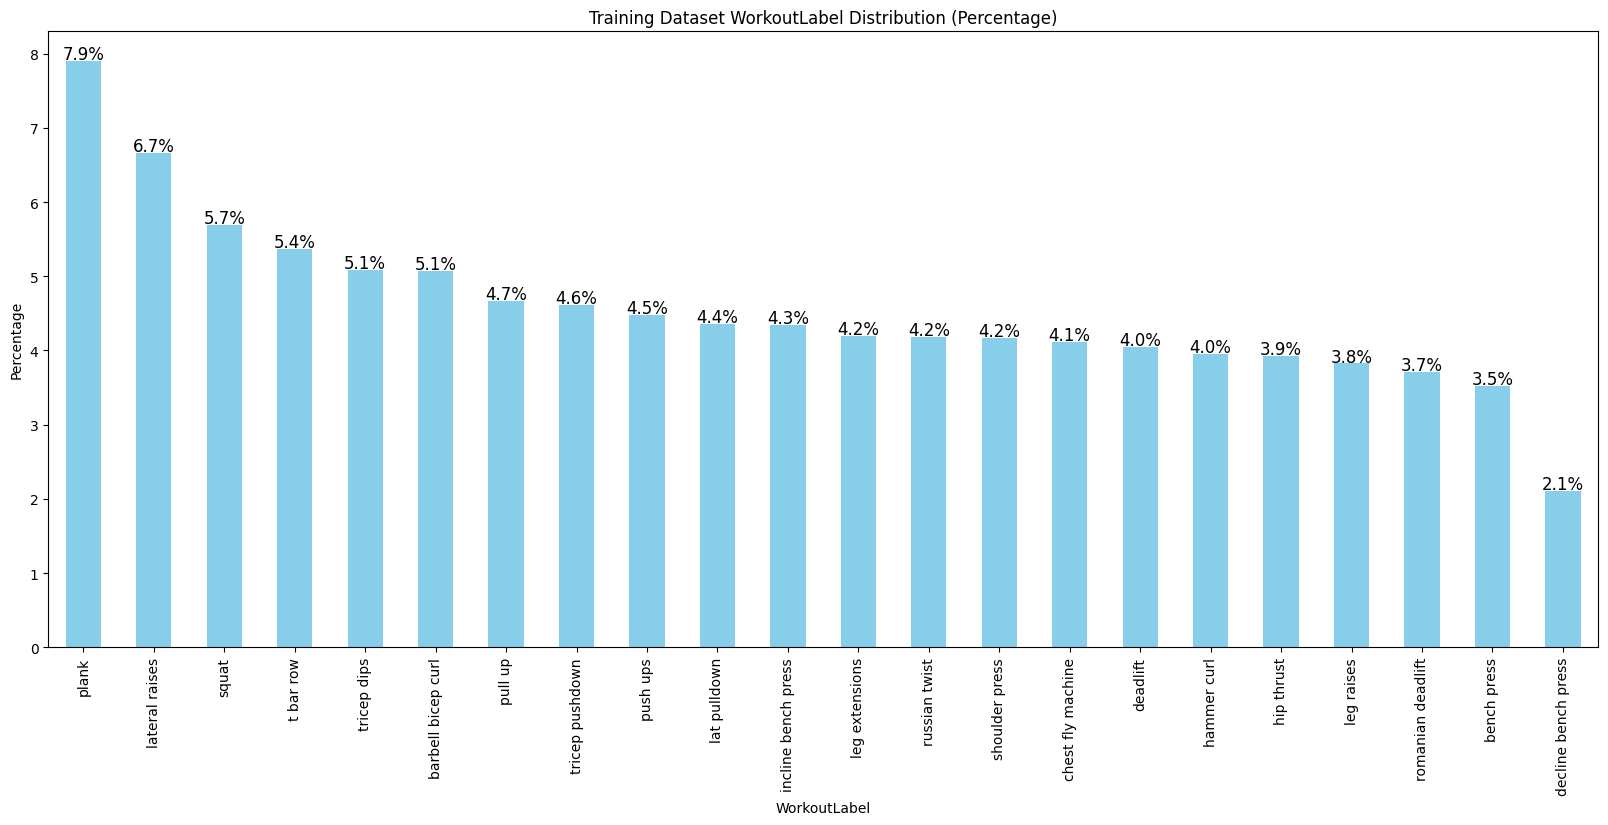

In [84]:
plt.figure(figsize=(20,8))
value_counts = training_dataset['WorkoutLabel'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Plot
ax = percentages.plot(kind='bar', color='skyblue')

# Add percentage text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Training Dataset WorkoutLabel Distribution (Percentage)')
plt.ylabel('Percentage')
plt.show()

**4. Preprocessing**

**We have to make sure that we get right of Unamed 0: column, as it just contains numerical index not very useful, might lead to overfitting if it is left**
- Get rid of Unnamed 0:
- Get rid of image
- Get rid of muscle group
- split each feature into x,y,z components, then remove that original feature


In [85]:
training_dataset

,Unnamed: 0,image,label,muscle group,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,WorkoutLabel
0,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,14,2,"[0.4076772, 0.53859503, -0.43176422]","[0.30212419, 0.53329417, -0.08373189]","[0.47755241, 0.62829471, -0.48015693]","[0.36572888, 0.60832077, 0.06896935]","[0.45841879, 0.77347238, -0.46713212]","[0.31301635, 0.72137594, 0.14868972]","[0.56939434, 0.54643219, -0.12819768]","[0.51242, 0.57381809, 0.10095789]","[0.63910025, 0.60599913, 0.1678605]","[0.63145864, 0.63356149, 0.34701145]","[0.76912415, 0.60492045, 0.41589585]","[0.73286533, 0.61557174, 0.62054408]",push ups
1,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,5,3,"[0.62158799, 0.37825048, 0.13248622]","[0.51870537, 0.37153426, -0.07180108]","[0.62934655, 0.49510396, 0.11096987]","[0.50695115, 0.52784979, -0.18593533]","[0.63863814, 0.44941157, 0.01945218]","[0.54406822, 0.45320496, -0.25432891]","[0.58263296, 0.68559128, 0.07403004]","[0.53926361, 0.69243735, -0.07392958]","[0.59003258, 0.9043318, 0.03599621]","[0.54054302, 0.92782676, -0.08952532]","[0.58181006, 1.08057749, 0.21025692]","[0.5167591, 1.09714866, 0.05454929]",hammer curl
2,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,19,7,"[0.59639569, 0.16613668, -0.39895398]","[0.44206485, 0.20809583, -0.07310521]","[0.65811093, 0.21082211, -0.36079545]","[0.49580455, 0.26151705, 0.20738904]","[0.63525659, 0.3768186, -0.25289935]","[0.52343197, 0.41021598, 0.13997659]","[0.59330189, 0.44754258, -0.12267438]","[0.54244798, 0.42781165, 0.12296394]","[0.57045128, 0.72300093, -0.16295381]","[0.52884918, 0.65270454, 0.03523069]","[0.58354467, 0.89388609, -0.11509742]","[0.55937612, 0.85571069, 0.21252289]",t bar row
3,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,7,"[0.74283612, 0.54354161, -0.41493109]","[0.6320287, 0.54556936, -0.38880739]","[0.75557572, 0.69494408, -0.41101938]","[0.61310405, 0.70047724, -0.37841684]","[0.76417828, 0.81841254, -0.44868124]","[0.32827542, 0.65916561, -0.50096271]","[0.71539277, 0.62132698, -0.00213909]","[0.65179229, 0.6192534, 0.00214438]","[0.74565494, 0.72543031, -0.36834845]","[0.6247564, 0.72221029, -0.34035262]","[0.73384804, 0.90416259, -0.12565227]","[0.41557825, 0.96615031, -0.40778989]",deadlift
4,4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,5,"[0.56809147, 0.37226242, -0.39718493]","[0.64721616, 0.28449151, 0.10545303]","[0.58725971, 0.57337648, -0.27993616]","[0.60590367, 0.48719001, 0.06806469]","[0.49152815, 0.52335042, -0.01631748]","[0.54312587, 0.53614379, -0.10371782]","[0.65693825, 0.66779613, -0.13540807]","[0.66245359, 0.64135772, 0.13534579]","[0.62787843, 0.94229418, -0.08090317]","[0.6641224, 0.88043618, 0.24074768]","[0.67723244, 1.0759306, 0.17884697]","[0.68238389, 1.0658257, 0.40704015]",tricep pushdown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,20,5,"[0.43117046, 0.41211745, 0.1395963]","[0.36641935, 0.28952429, -0.29701805]","[0.33957642, 0.57077129, 0.18344573]","[0.309001, 0.41244426, -0.27733115]","[0.38687432, 0.62827963, -0.04124875]","[0.34835592, 0.61631447, -0.29728013]","[0.28386286, 0.56490141, 0.11776229]","[0.25893655, 0.53659767, -0.11795145]","[0.29759184, 0.74774677, 0.16131496]","[0.32578319, 0.72492176, -0.06239227]","[0.25300202, 0.84858249, 0.27881202]","[0.2054995, 0.85112685, 0.1908187]",tricep dips
19996,19996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,5,3,"[0.23098492, 0.64275314, -0.04447381]","[0.13669592, 0.67260225, -0.1595023]","[0.21530151, 0.72202575, -0.02227739]","[0.1209834, 0.80038726, -0.13689627]","[0.20740512, 0.80313611, -0.09368004]","[0.15252867, 0.79425475, -0.16270298]","[0.19554484, 0.81770819, 0.04990623]","[0.13550399, 0.83927965, -0.04959911]","[0.29787469, 0.84483069, -0.16346391]","[0.21270198, 0.84856818, -0.30378741]","[0.25687416, 0.9833

In [86]:
training_dataset['left_ankle']

0         [0.76912415, 0.60492045, 0.41589585]
1         [0.58181006, 1.08057749, 0.21025692]
2        [0.58354467, 0.89388609, -0.11509742]
3        [0.73384804, 0.90416259, -0.12565227]
4          [0.67723244, 1.0759306, 0.17884697]
                         ...                  
19995     [0.25300202, 0.84858249, 0.27881202]
19996     [0.25687416, 0.98337908, 0.04075424]
19997     [0.42472577, 0.85501015, 0.38475958]
19998     [0.62613416, 1.27349854, 0.42942172]
19999    [0.55860096, 0.92952418, -0.06205887]
Name: left_ankle, Length: 20000, dtype: object

In [87]:
"""
Removes original feature and splits it into x,y,z components

"""
def Preprocess_data(dataframe,columns_to_flatten):
    final_df=dataframe.copy()
    # Expanding each column into 3 separate columns (x, y, z) and appending it to the final dataframe.
    for column in columns_to_flatten:
        # print(np.vstack(dataframe[column]).astype(float))
        expanded_df=pd.DataFrame(np.vstack(dataframe[column]).astype(float), 
                           columns=[column+'_x', column+'_y', column+'_z'],
                           index=dataframe.index)
        new_df = pd.concat([dataframe.drop(column, axis=1), expanded_df], axis=1)
        for new_column in new_df.columns:
            final_df[new_column] = new_df[new_column]

    return final_df.drop(columns=columns_to_flatten,axis=1)

"""
Splits dataset into X_train,y_train or X_test,y_test, if you give it training dataset then X_train and y_train

"""
def Return_X_y(dataframe,columns_to_delete):
    X=dataframe.drop(columns=columns_to_delete)
    y=dataframe['label']
    return X,y

In [88]:
features_to_split=['left_shoulder',
       'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
       'right_wrist', 'left_hip', 'right_hip', 'left_knee',
       'right_knee', 'left_ankle', 'right_ankle']

training_dataset_preprocessed=Preprocess_data(training_dataset,features_to_split)
X_train, y_train = Return_X_y(training_dataset_preprocessed,['label','muscle group','WorkoutLabel','image','Unnamed: 0'])


testing_dataset_preprocessed=Preprocess_data(testing_dataset,features_to_split)
X_test, y_test = Return_X_y(testing_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

validation_dataset_preprocessed=Preprocess_data(validation_dataset,features_to_split)
X_validation, y_validation = Return_X_y(validation_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

In [89]:
print("X_train Shape",X_train.shape)

print("y_train Shape",y_train.shape)

print("X_test Shape",X_test.shape)

print("y_test Shape",y_test.shape)

X_train Shape (20000, 36)
y_train Shape (20000,)
X_test Shape (11286, 36)
y_test Shape (11286,)


**66 Features is all the features**

**5. Feature Engineering**

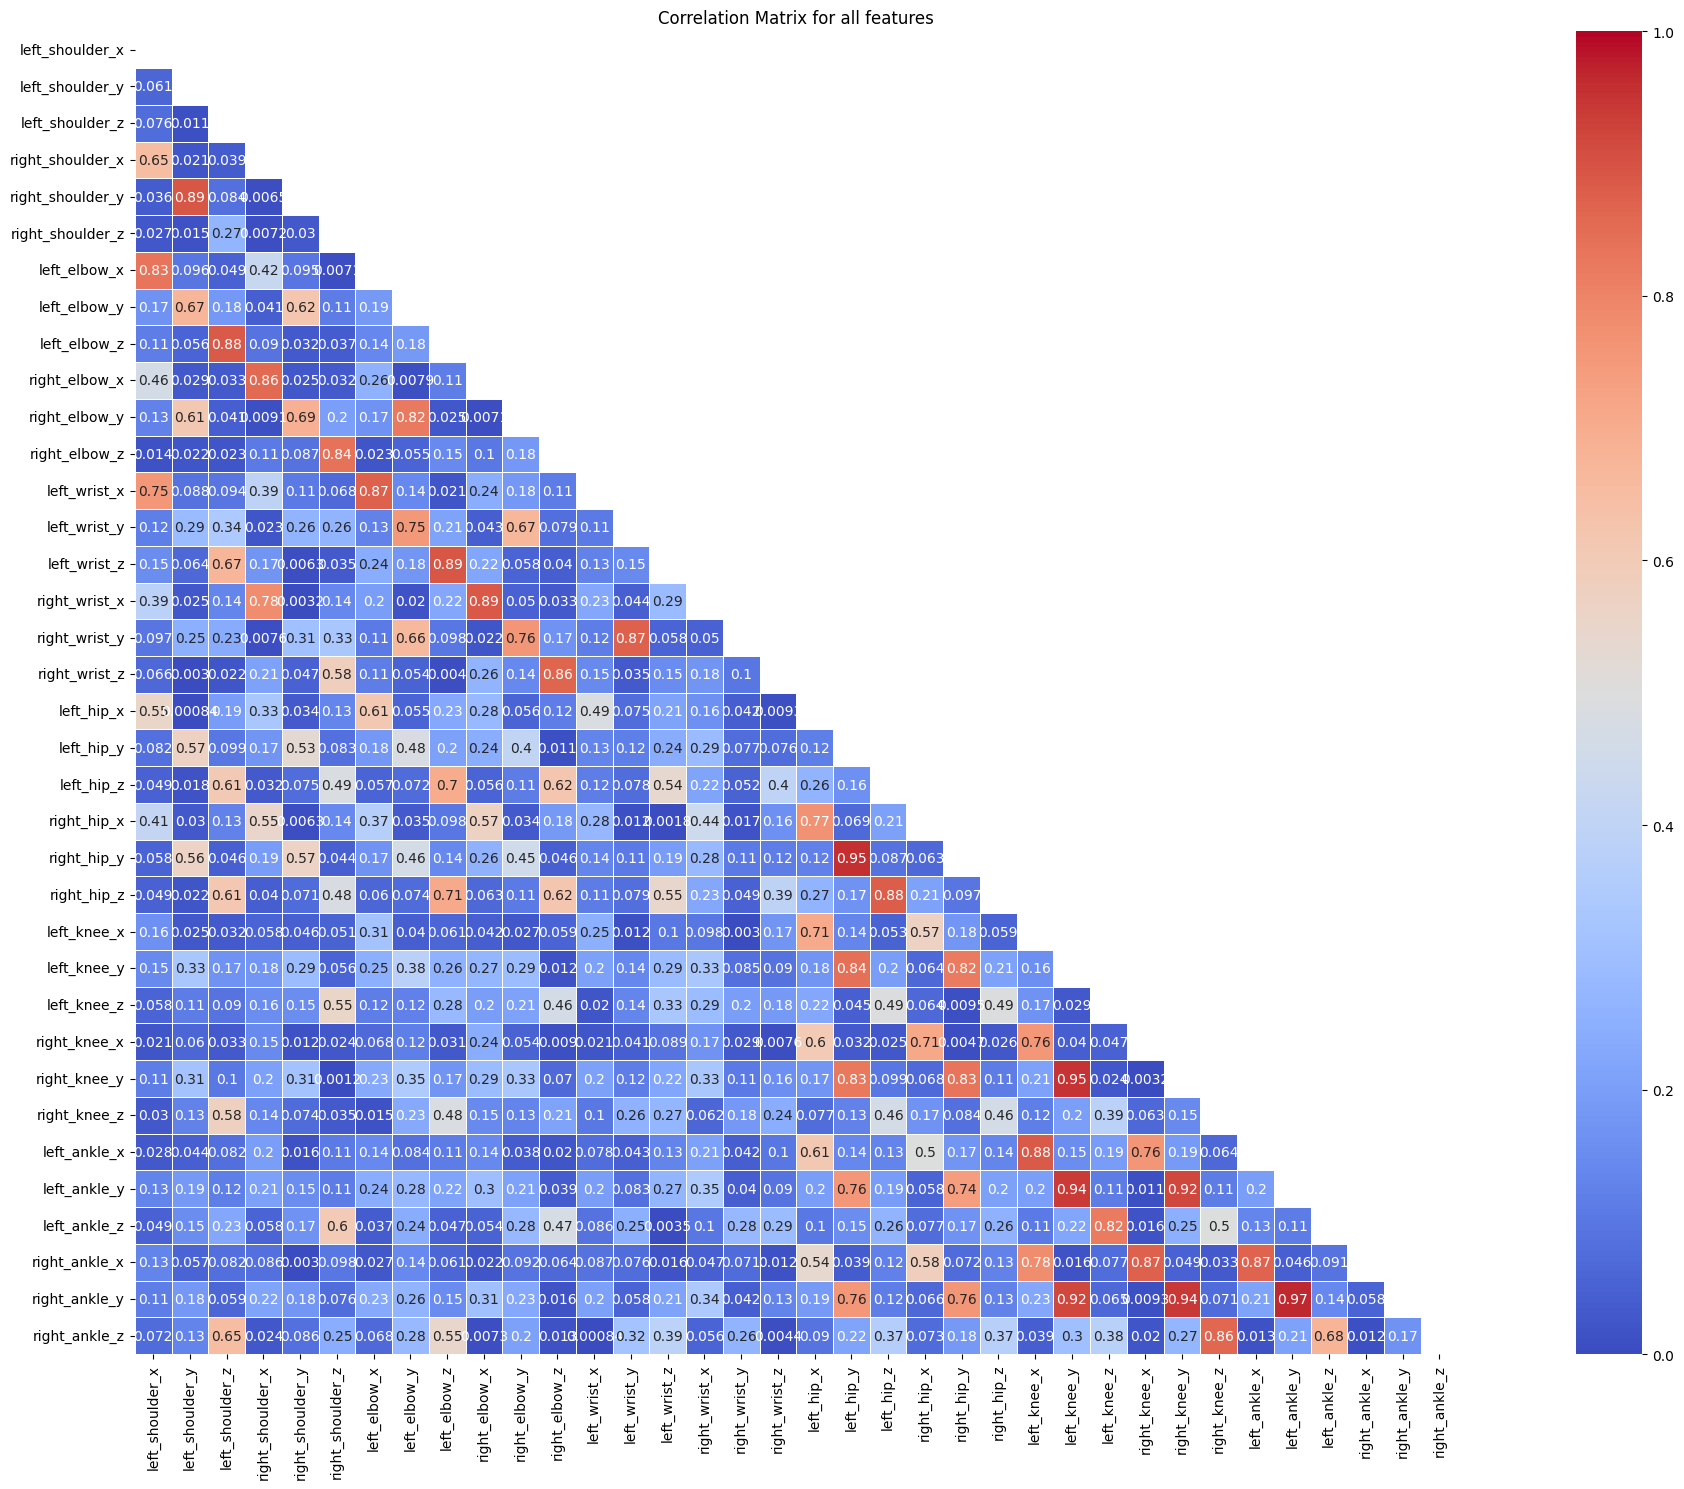

In [90]:
corr_matrix = X_train.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(24, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            vmax=1.0, vmin=0, center=0.5,
            square=True, linewidths=.5, annot=True).set(title='Correlation Matrix for all features')
plt.tight_layout()
plt.show()

**Features that are highly correlated , one of them should be removed**
- it is better to remove the one that is the least correlated with y_target

In [91]:
correlation_threshold = 0.8
columns_to_drop = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > correlation_threshold:
            columns_to_drop.append(corr_matrix.columns[j])
            print(f"High Correlation between {corr_matrix.columns[i]} and {corr_matrix.columns[j]} --> {corr_matrix.iloc[i, j]:.2f}")

columns_to_drop = list(set(columns_to_drop))
print(f"Columns to drop: {columns_to_drop}")
print(f"number of columns to drop: {len(columns_to_drop)}")

High Correlation between left_shoulder_x and left_elbow_x --> 0.83
High Correlation between left_shoulder_y and right_shoulder_y --> 0.89
High Correlation between left_shoulder_z and left_elbow_z --> 0.88
High Correlation between right_shoulder_x and right_elbow_x --> 0.86
High Correlation between right_shoulder_z and right_elbow_z --> 0.84
High Correlation between left_elbow_x and left_wrist_x --> 0.87
High Correlation between left_elbow_y and right_elbow_y --> 0.82
High Correlation between left_elbow_z and left_wrist_z --> 0.89
High Correlation between right_elbow_x and right_wrist_x --> 0.89
High Correlation between right_elbow_z and right_wrist_z --> 0.86
High Correlation between left_wrist_y and right_wrist_y --> 0.87
High Correlation between left_hip_y and right_hip_y --> 0.95
High Correlation between left_hip_y and left_knee_y --> 0.84
High Correlation between left_hip_y and right_knee_y --> 0.83
High Correlation between left_hip_z and right_hip_z --> 0.88
High Correlation betwe

In [92]:
print(f"Columns to drop: {columns_to_drop}")


Columns to drop: ['right_shoulder_y', 'right_elbow_x', 'right_wrist_x', 'right_wrist_y', 'right_knee_y', 'left_elbow_z', 'right_elbow_z', 'left_ankle_x', 'right_elbow_y', 'right_ankle_x', 'left_ankle_y', 'right_ankle_y', 'right_hip_z', 'left_wrist_x', 'right_hip_y', 'right_ankle_z', 'right_wrist_z', 'left_wrist_z', 'left_ankle_z', 'left_elbow_x', 'left_knee_y']


**53 Columns to drop**

In [93]:
X_train_feature_eng=X_train.drop(columns=columns_to_drop)
X_test_feature_eng=X_test.drop(columns=columns_to_drop)

In [94]:
X_train_feature_eng

,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_z,left_elbow_y,left_wrist_y,left_hip_x,left_hip_y,left_hip_z,right_hip_x,left_knee_x,left_knee_z,right_knee_x,right_knee_z
0,0.407677,0.538595,-0.431764,0.302124,-0.083732,0.628295,0.773472,0.569394,0.546432,-0.128198,0.512420,0.639100,0.167860,0.631459,0.347011
1,0.621588,0.378250,0.132486,0.518705,-0.071801,0.495104,0.449412,0.582633,0.685591,0.074030,0.539264,0.590033,0.035996,0.540543,-0.089525
2,0.596396,0.166137,-0.398954,0.442065,-0.073105,0.210822,0.376819,0.593302,0.447543,-0.122674,0.542448,0.570451,-0.162954,0.528849,0.035231
3,0.742836,0.543542,-0.414931,0.632029,-0.388807,0.694944,0.818413,0.715393,0.621327,-0.002139,0.651792,0.745655,-0.368348,0.624756,-0.340353
4,0.568091,0.372262,-0.397185,0.647216,0.105453,0.573376,0.523350,0.656938,0.667796,-0.135408,0.662454,0.627878,-0.080903,0.664122,0.240748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.431170,0.412117,0.139596,0.366419,-0.297018,0.570771,0.628280,0.283863,0.564901,0.117762,0.258937,0.297592,0.161315,0.325783,-0.062392
19996,0.230985,0.642753,-0.044474,0.136696,-0.159502,0.722026,0.803136,0.195545,0.817708,0.049906,0.135504,0.297875,-0.163464,0.212702,-0.303787
19997,0.489146,0.248440,-0.104891,0.440066,-0.644197,0.420367,0.590288,0.355658,0.437530,0.101401,0.299410,0.644459,0.486560,0.178091,0.018719
19998,0.682516,0.320391,-0.128162,0.472623,-0.101331,0.609716,0.545291,0.573646,0.757315,0.041166,0.509355,0.633974,-0.066448,0.465230,0.093792


In [95]:
X_train.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z',
       'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y',
       'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y',
       'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z',
       'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x',
       'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y',
       'right_ankle_z'],
      dtype='object')

In [96]:
X_train_feature_eng.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_z', 'left_elbow_y', 'left_wrist_y',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'left_knee_x',
       'left_knee_z', 'right_knee_x', 'right_knee_z'],
      dtype='object')

In [97]:
"""
This function takes both training_dataset
then it will show the result for each one of the models

1-Accuracy
2-Classification Report
3-Confusion Matrix
4-Precision, Recall, F1-Score
5-Time Taken to train
6-Features used to build the model

"""

def train_model(model,param_grid,X_train,y_train,X_test,y_test):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=2,
        scoring='accuracy'
    )
    grid_search.fit(X_train,y_train)
    y_predictions=grid_search.predict(X_test)
    accuracy = accuracy_score(y_test,y_predictions)
    report = classification_report(y_test,y_predictions)
    confusion_matrix_values = confusion_matrix(y_test,y_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', cbar=True, 
                xticklabels=Workout_labels,
                yticklabels=Workout_labels)

    # Add labels, title, and axis ticks
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')

    # Show the plot
    plt.show()
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", (accuracy*100),"%")
    print("Classification Report:\n", report)
    return grid_search

**Random Forest**

In [98]:
param_grid = {
    'n_estimators': [1000],
    'max_depth': [20],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['sqrt', 'log2', None]
}



**Random Forest with no feature engineering**

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....................max_depth=20, n_estimators=1000; total time=  49.5s
[CV] END ....................max_depth=20, n_estimators=1000; total time=  49.6s
[CV] END ....................max_depth=20, n_estimators=1000; total time=  49.6s


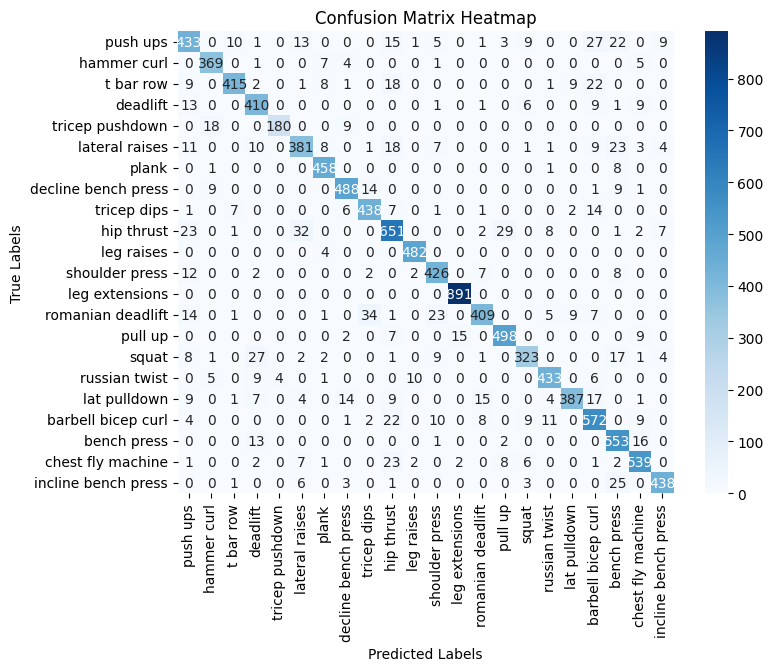

Best Parameters: {'max_depth': 20, 'n_estimators': 1000}
Accuracy: 90.147084883927 %
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80       549
           1       0.92      0.95      0.93       387
           2       0.95      0.85      0.90       486
           3       0.85      0.91      0.88       450
           4       0.98      0.87      0.92       207
           5       0.85      0.80      0.83       477
           6       0.93      0.98      0.96       468
           7       0.92      0.93      0.93       522
           8       0.89      0.92      0.90       477
           9       0.84      0.86      0.85       756
          10       0.97      0.99      0.98       486
          11       0.88      0.93      0.90       459
          12       0.98      1.00      0.99       891
          13       0.92      0.81      0.86       504
          14       0.92      0.94      0.93       531
          15       0.90   

In [99]:
random_tree_model = RandomForestClassifier(random_state=42)
rfc_model = train_model(random_tree_model,param_grid,X_train,y_train,X_test,y_test)

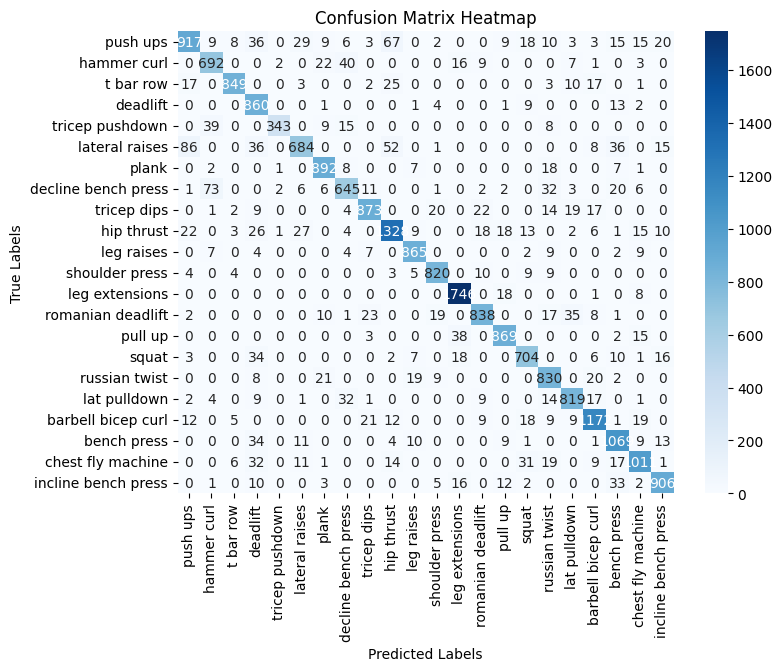

Best Parameters: {'max_depth': 20, 'n_estimators': 1000}
Accuracy: 89.74393960067313 %
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      1179
           1       0.84      0.87      0.85       792
           2       0.97      0.92      0.94       927
           3       0.78      0.97      0.86       891
           4       0.98      0.83      0.90       414
           5       0.89      0.75      0.81       918
           6       0.92      0.95      0.93       936
           7       0.85      0.80      0.82       810
           8       0.92      0.89      0.91       981
           9       0.88      0.88      0.88      1503
          10       0.94      0.95      0.94       909
          11       0.93      0.95      0.94       864
          12       0.95      0.98      0.97      1773
          13       0.91      0.88      0.90       954
          14       0.93      0.94      0.93       927
          15       0.87 

In [100]:
y_predictions=rfc_model.predict(X_validation)
accuracy = accuracy_score(y_validation,y_predictions)

report = classification_report(y_validation,y_predictions)
confusion_matrix_values = confusion_matrix(y_validation,y_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=Workout_labels,
            yticklabels=Workout_labels)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()
print("Best Parameters:", rfc_model.best_params_)
print("Accuracy:", (accuracy*100),"%")
print("Classification Report:\n", report)

**Random Forest with feature engineering**

In [ ]:
train_model(random_tree_model,param_grid,X_train_feature_eng,y_train,X_test_feature_eng,y_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....................max_depth=20, n_estimators=1000; total time=  27.8s
[CV] END ....................max_depth=20, n_estimators=1000; total time=  27.8s
[CV] END ....................max_depth=20, n_estimators=1000; total time=  27.9s


**Multilayer Perceptron**

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],  
    # 'activation': ['relu', 'tanh'],  
    # 'solver': ['adam', 'sgd'],  
    # 'alpha': [0.0001, 0.001, 0.01],  
    # 'learning_rate': ['constant', 'adaptive'],  
    # 'max_iter': [200, 500, 1000]  
}

**Multilayer Perceptron with no feature engineering**

In [ ]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Multilayer Perceptron with feature engineering**

In [ ]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Support Vector Machines**

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto'],  
}

In [ ]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [ ]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Upsampling the training dataset, then comparing the results to above**
- Applying SMOTE to make sure all classes are evenly distributed